Analyzing the baroclinic tide at VENUS nodes

In [1]:
import datetime
import matplotlib.pylab as plt
import numpy as np
import netCDF4 as nc

from salishsea_tools import (viz_tools,tidetools, nc_tools, ellipse)
from salishsea_tools.nowcast import (research_VENUS, analyze)

import baroclinic as bc

import seaborn as sns

%matplotlib inline

In [2]:
sns.set_style('darkgrid')
sns.set_color_codes()

In [3]:
path='/data/dlatorne/MEOPAR/SalishSea/nowcast/'
SITES = research_VENUS.SITES['VENUS']
NodalCorr = tidetools.CorrTides

In [4]:
to=datetime.datetime(2014,11,26)
tf=datetime.datetime(2015,4,26)
us = {}; vs = {}; depths= {}; times={}

for site in SITES:
    fname = '{}_currents_{}_{}.nc'.format(site, to.strftime('%Y%m%d'), tf.strftime('%Y%m%d'))
    
    f = nc.Dataset(fname)
    
    us[site] = f.variables['vozocrtx'][:]
    vs[site] = f.variables['vomecrty'][:]
    depths[site] = f.variables['deptht'][:]
    times[site] = f.variables['time_counter'][:]

Question - should I exclude the surface/bottom layer in the depth averaged currents or not?

Let's try not for now. Will think of a better option in the future.

#Barotopic tidal analysis - Ellipses and U/V

In [5]:
nconst=8
barotropic_ellipse ={} # barotropic ellipse parameters (depth averaged)
u_rot ={}; v_rot={} #rotated full currents
u_rot_depav={}; v_rot_depav={} # rotated, depth averaged currents
u_tide_bt={}; v_tide_bt={} # barotropic tidal constituents (depth averaged)
for site in SITES:
    u_rot[site],v_rot[site] = ellipse.prepare_vel(us[site], vs[site])
    #ellipses and tide fits for u/ rotates
    u_rot_depav[site],v_rot_depav[site] = ellipse.prepare_vel(us[site], vs[site], depav=True, depth=depths[site])
    u_tide_bt[site] = tidetools.fittit(u_rot_depav[site][:,0,0],times[site], nconst )
    v_tide_bt[site] = tidetools.fittit(v_rot_depav[site][:,0,0],times[site], nconst )
    #nodal corrections
    u_tide_bt[site] = bc.nodal_corrections(u_tide_bt[site], NodalCorr)
    v_tide_bt[site] = bc.nodal_corrections(v_tide_bt[site], NodalCorr)
    
    barotropic_ellipse[site] = ellipse.get_params(u_rot_depav[site], v_rot_depav[site], times[site], nconst, 
                                                  tidecorr=NodalCorr)

Construct barotopic tidal curents prediction (U/V)

In [6]:
u_bt_pred = {} #barotopic tidal prediction - u
v_bt_pred = {} #barotropic tidal predition - v

for site in SITES:
    u_bt_pred[site] = np.zeros(len(times[site]))
    v_bt_pred[site] = np.zeros(len(times[site]))
    for const in u_tide_bt[site]:
        ampU = u_tide_bt[site][const]['amp'] * NodalCorr[const]['ft']
        phaU = u_tide_bt[site][const]['phase'] - NodalCorr[const]['uvt']
        u_bt_pred[site] = u_bt_pred[site] + ampU*np.cos((NodalCorr[const]['freq']*np.array(times[site]) - phaU)*np.pi/180)
        
        ampV = v_tide_bt[site][const]['amp'] * NodalCorr[const]['ft']
        phaV = v_tide_bt[site][const]['phase'] - NodalCorr[const]['uvt']
        v_bt_pred[site] = v_bt_pred[site] + ampV*np.cos((NodalCorr[const]['freq']*np.array(times[site]) - phaV)*np.pi/180)
        

Check that phase, etc is reasonable by plotting

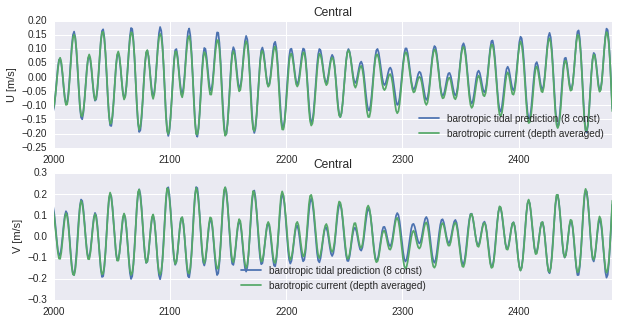

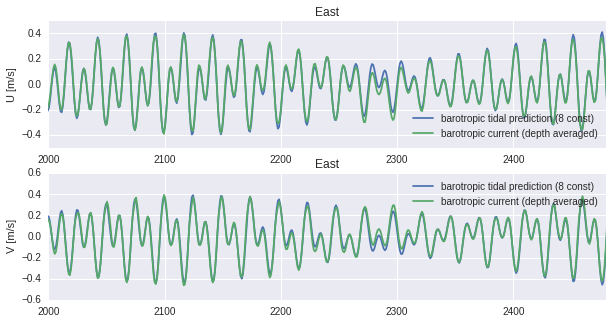

In [7]:
numdays = 20
for site in ['Central', 'East']:
    fig,axs=plt.subplots(2,1, figsize=(10,5))
    ax=axs[0]
    ax.plot(times[site], u_bt_pred[site],label='barotropic tidal prediction (8 const)')
    ax.plot(times[site], u_rot_depav[site][:,0,0] - np.mean(u_rot_depav[site]),
            label = 'barotropic current (depth averaged)')
    ax.legend(loc=0)
    ax.set_ylabel('U [m/s]')
    ax.set_title(site)
    ax.set_xlim([2000,2000+24*numdays])
    ax=axs[1]
    ax.plot(times[site], v_bt_pred[site],label='barotropic tidal prediction (8 const)')
    ax.plot(times[site], v_rot_depav[site][:,0,0] - np.mean(v_rot_depav[site]),
            label = 'barotropic current (depth averaged)')
    ax.legend(loc=0)
    ax.set_ylabel('V [m/s]')
    ax.set_title(site)
    ax.set_xlim([2000,2000+24*numdays])

Prediction looks very reasonable - amplitude/phase aligned for both U/V at Central and East

#Baroclinic Tide

In [8]:
u_tide_bc = {} #baroclinc tidal constituents - u
v_tide_bc = {} # baroclinic tidal constitnets - v
u_bc = {} # barocinic current - u
v_bc = {} # baroclinic current - v
baroclinic_ellipse = {} # ellipse values for baroclinic tide

for site in SITES:
    u_tide_bc[site], u_bc[site] = bc.baroclinic_tide(u_rot[site][:,:,0,0], times[site], depths[site], nconst)
    v_tide_bc[site], v_bc[site] = bc.baroclinic_tide(v_rot[site][:,:,0,0], times[site], depths[site], nconst)
    #nodal corrections
    u_tide_bc[site] = bc.nodal_corrections(u_tide_bc[site], NodalCorr)
    v_tide_bc[site] = bc.nodal_corrections(v_tide_bc[site], NodalCorr)
    baroclinic_ellipse[site] = ellipse.get_params(u_bc[site], v_bc[site], times[site], nconst, tidecorr=NodalCorr)

##Ellipse parameters

In [9]:
def plot_ellipse_params(site, dmin=0, dmax=350):
    """Plots the depth profile of ellipse parameters at a site e.g Central, East, ddl"""
    units = {'Phase': 'deg', 'Inclination': 'deg CCW E', 'Semi-Major Axis': 'm/s', 'Semi-Minor Axis': 'm/s'}
    fig, axs = plt.subplots(2,2,figsize=(10,10))
    for const , c in zip(['M2', 'K1'], ['b','g']):
        for ax, param in zip(axs.flatten(), baroclinic_ellipse[site][const]):
            if param=='Phase':
                #ax.plot(baroclinic_ellipse[site][const][param], 
                #        depths[site], label =const,color=c)
                #adjust to phase to avoid jumping and supposed discontinuites.
                adjphase = np.rad2deg(np.unwrap(np.deg2rad(baroclinic_ellipse[site][const][param]))) 
                if site =='East' and const =='K1':
                    adjphase = adjphase+360
                ax.plot(adjphase, depths[site], label =const,color=c)
                bt_phase = barotropic_ellipse[site][const][param][:,0]
                ax.plot([bt_phase,bt_phase], [depths[site][0],depths[site][-1]],'--',
                        label='{} barotropic'.format(const), color=c)
            else:
                ax.plot( baroclinic_ellipse[site][const][param], depths[site], label =const)
            ax.set_title(param)
            ax.set_ylim([dmax, dmin])
            ax.legend(loc=0)
            ax.set_xlabel(units[param])
            ax.set_ylabel('Depth [m]')
    return fig

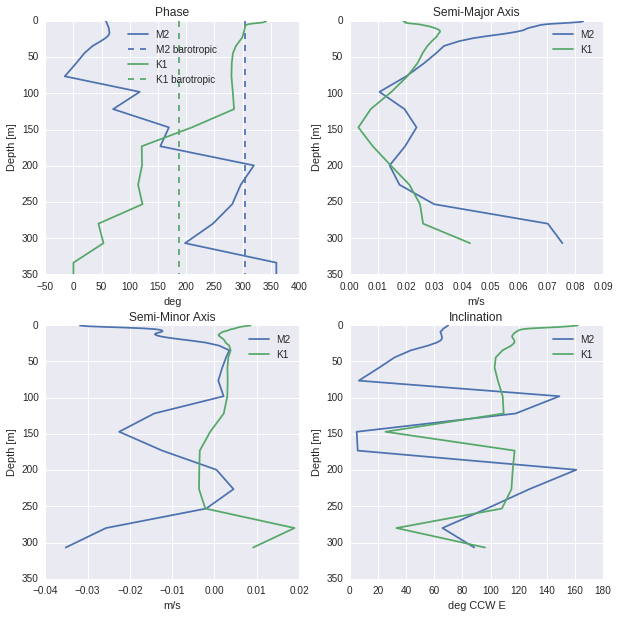

In [10]:
site = 'Central'

fig = plot_ellipse_params(site)

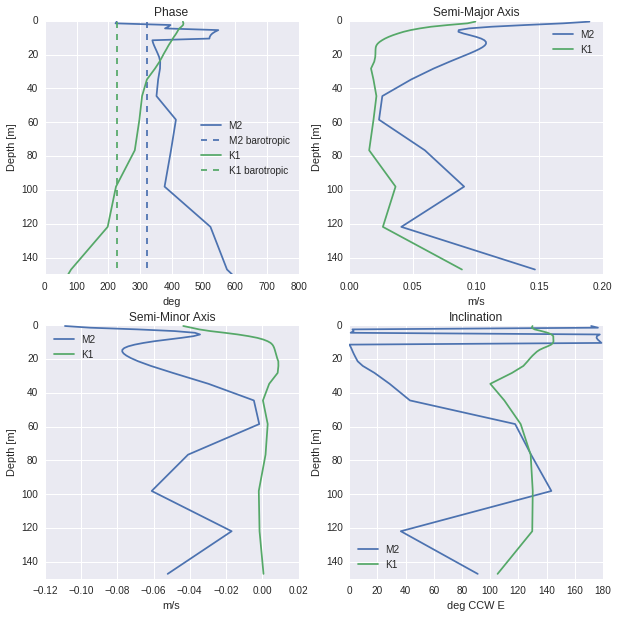

In [11]:
site = 'East'

fig = plot_ellipse_params(site,dmin=0,dmax=150)

In [12]:
dep = 0
print 'Baroclinic Phase at {0:.3g} m /  Barotropic Phase'.format(depths[site][dep])
for site in SITES:
    print site
    for const in ['M2','K1']:
        print const, baroclinic_ellipse[site][const]['Phase'][dep], barotropic_ellipse[site][const]['Phase'][0,0]

Baroclinic Phase at 0.5 m /  Barotropic Phase
East
M2 226.584033661 321.567283027
K1 75.2703783712 226.543788998
Central
M2 57.2581651527 304.236550188
K1 341.918548993 186.529169425
ddl
M2 254.966035753 317.552723597
K1 98.9735655741 240.205739444


* East
    * M2 baroclinic phase at surface is 100 deg different from barotropic phase
* Central
    * M2 baroclinic phase at surface is 110 deg different from barotropic phase
* DDL
    * M2 baroclinic phase at surface is 60 deg different from barotropic phase

Create baroclinic tidal prediction

In [13]:
u_bc_pred={}
v_bc_pred={}
for site in SITES:
    u_bc_pred[site] = np.zeros((len(times[site]), 40))
    v_bc_pred[site] = np.zeros((len(times[site]),40))
    for const in u_tide_bc[site]:
        ampU = u_tide_bc[site][const]['amp'] * NodalCorr[const]['ft']
        phaU = u_tide_bc[site][const]['phase'] - NodalCorr[const]['uvt'] 

        ampV = v_tide_bc[site][const]['amp'] * NodalCorr[const]['ft']
        phaV = v_tide_bc[site][const]['phase'] - NodalCorr[const]['uvt'] 
        for k in np.arange(u_bc_pred[site].shape[-1]):
            u_bc_pred[site][:,k] = u_bc_pred[site][:,k] + ampU[k]*np.cos((NodalCorr[const]['freq']*np.array(times[site]) - phaU[k])*np.pi/180)
            v_bc_pred[site][:,k] = v_bc_pred[site][:,k] + ampV[k]*np.cos((NodalCorr[const]['freq']*np.array(times[site]) - phaV[k])*np.pi/180)
        

#Sanity checks


##Comparison of baroclinic tidal prediction with baroclinic current 
At surface

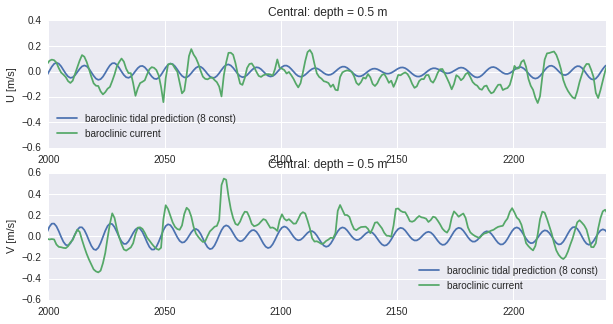

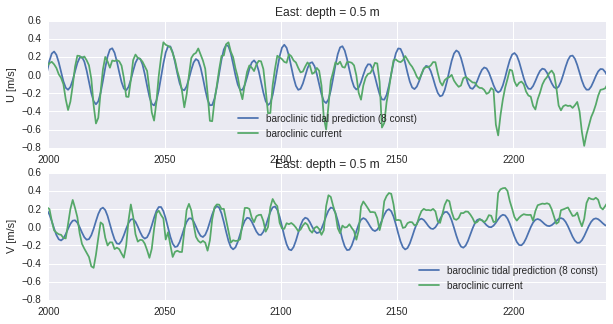

In [14]:
dep=0
numdays=10
for site in ['Central', 'East']:
    fig,axs=plt.subplots(2,1, figsize=(10,5))
    ax=axs[0]
    ax.plot(times[site], u_bc_pred[site][:,dep],label='baroclinic tidal prediction (8 const)')
    ax.plot(times[site], u_bc[site][:,dep]- np.nanmean(u_bc[site][:,dep]),
            label = 'baroclinic current')
    ax.legend(loc=0)
    ax.set_ylabel('U [m/s]')
    ax.set_title('{0}: depth = {1:.2g} m'.format(site, depths[site][dep]))
    ax.set_xlim([2000,2000+24*numdays])
    ax=axs[1]
    ax.plot(times[site], v_bc_pred[site][:,dep],label='baroclinic tidal prediction (8 const)')
    ax.plot(times[site], v_bc[site][:,dep] - np.nanmean(v_bc[site][:,dep]),
            label = 'baroclinic current '.format(dep))
    ax.legend(loc=0)
    ax.set_ylabel('V [m/s]')
    ax.set_title('{0}: depth = {1:.2g} m'.format(site, depths[site][dep]))
    ax.set_xlim([2000,2000+24*numdays])

There looks to be a lot of noise in the baroclinic current. Yet another reason to use t_tide.

Am I doing this right! I did the same thing with the barotropic (I think...)

## Barotopic tidal predicion compared with baroclinic

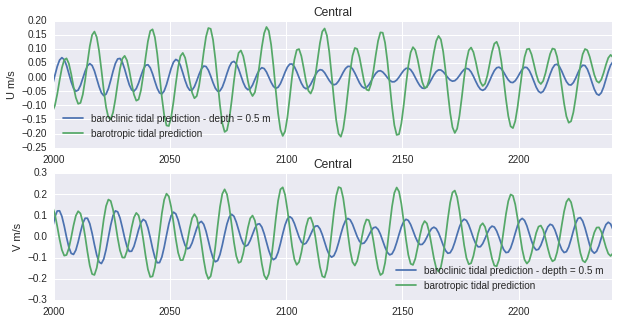

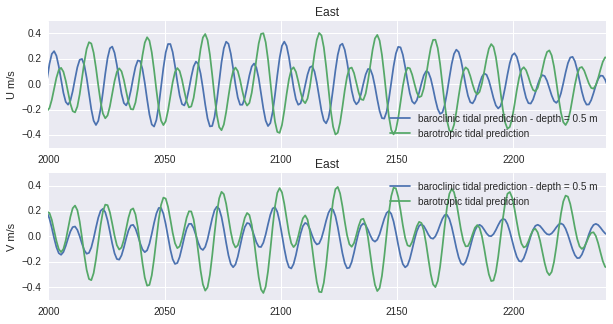

In [15]:
dep=0
numdays=10
for site in ['Central','East']:
    fig,axs=plt.subplots(2,1,figsize=(10,5))
    ax=axs[0]
    ax.plot(times[site], u_bc_pred[site][:,dep],
            label='baroclinic tidal prediction - depth = {0:.2g} m'.format(depths[site][dep]))
    ax.plot(times[site], u_bt_pred[site],label='barotropic tidal prediction')
    ax.set_xlim([2000,2000+24*numdays])
    ax.legend(loc=0)
    ax.set_ylabel('U m/s')
    ax.set_title(site)
    ax=axs[1]
    ax.plot(times[site], v_bc_pred[site][:,dep],
            label = 'baroclinic tidal prediction - depth = {0:.2g} m'.format(depths[site][dep]))
    ax.plot(times[site], v_bt_pred[site],label='barotropic tidal prediction')
    ax.set_xlim([2000,2000+24*numdays])
    ax.legend(loc=0)
    ax.set_ylabel('V m/s')
    ax.set_title(site)

###M2 Phase for U/V Baroclinic and Barotropic

In [16]:
const = 'M2'
dep=0
for site in ['Central', 'East']:
    print site
    print 'Baroclinic U', u_tide_bc[site][const]['phase'][dep]
    print 'Barotropic U', u_tide_bt[site][const]['phase']
    print 'Baroclinic V', v_tide_bc[site][const]['phase'][dep]
    print 'Barotropic V', v_tide_bt[site][const]['phase']

Central
Baroclinic U 103.618752163
Barotropic U 129.494201461
Baroclinic V 49.2760656238
Barotropic V -59.2545484312
East
Baroclinic U 41.782733375
Barotropic U 138.197130211
Baroclinic V -57.6643074575
Barotropic V -35.0290340623


Central
* U in phase, V out of phase

East
* U in phase, V out of phase

U/V are the East/west and North/Sout velocities. They are NOT aligned with the model grid.